In [26]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [27]:
df = sns.load_dataset("mpg")

X_train, y_train = df[~df["horsepower"].isna()][["displacement", "acceleration"]], df[~df["horsepower"].isna()]["horsepower"]
X_pred = df[df["horsepower"].isna()][["displacement", "acceleration"]]

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_pred)
y_pred = np.round(y_pred)
df.loc[X_pred.index, "horsepower"] = y_pred
df = pd.get_dummies(df.drop("name", axis = 1), columns = ["origin"])
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_europe,origin_japan,origin_usa
0,18.0,8,307.0,130.0,3504,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449,10.5,70,0,0,1


In [28]:
X, y = df.drop(["mpg"], axis = 1).values, df["mpg"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [29]:
scaler = StandardScaler()
#scaler = MinMaxScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

In [80]:
#from evolutionary_algos import EvoMLPRegressor

class EvoMLPRegressor:

    '''THIS IS THE ONE TO USE'''

    def __init__(self, n = 24, hidden_layers = False, activation = "relu", lr_decay = 20, random_state = None):

        self.n = int(round(n / 8) * 8)
        self.validation_loss_history = []
        self.training_loss_history = []
        self.random_state = random_state
        self.activation = activation
        self.lr_decay = lr_decay
        
        if hidden_layers:
            self.layers = hidden_layers + [1]
        else:
            self.layers = [1]

    def fit(self, X_train, y_train, epochs = 100, validation_data = False, verbose = 0):

        if self.random_state != None:
            np.random.seed(self.random_state)

        if validation_data:
            X_val, y_val = validation_data

        if self.activation == "sigmoid":
            activation_function = lambda x: 1 / (1 + np.exp(-x))
        elif self.activation == "leaky_relu":
            activation_function = lambda x: np.maximum(0.1 * x, x)
        elif self.activation == "relu":
            activation_function = lambda x: np.maximum(0, x)

        X_train = np.c_[np.ones(X_train.shape[0]), X_train]

        n = self.n
        ndiv4 = n // 4

        lr_decay = self.lr_decay

        layers = [X_train.shape[1]] + self.layers

        number_of_layers_minus_one = len(layers) - 1

        y_preds = np.zeros((n, y_train.shape[0]))

        nets_loss = np.zeros(n)
        sorted_indices = np.arange(-(ndiv4), n, 1)
        
        best_net_index = -1
        
        weights = []

        for i in range(number_of_layers_minus_one):
            weights += [np.random.normal(0, 2, (n, layers[i], layers[i + 1]))]

        for epoch in range(epochs):
            forward_pass = X_train.T
            
            for j in range(number_of_layers_minus_one - 1):
                forward_pass = activation_function(weights[j][sorted_indices[ndiv4:]].transpose(0, 2, 1) @ forward_pass)

            forward_pass = weights[-1][sorted_indices[ndiv4:]].transpose(0, 2, 1) @ forward_pass
            
            y_preds[sorted_indices[ndiv4:]] = forward_pass.reshape(*forward_pass.shape[::2])

            nets_loss[sorted_indices[ndiv4:]] = np.mean(np.abs(y_preds[sorted_indices[ndiv4:]] - y_train), axis = 1)

            sorted_indices = np.argsort(nets_loss)

            mutation_sigma = math.exp(-epoch / (epochs / (lr_decay * math.log10(epochs + 1)))) + 0.02 * math.exp(-(epoch + 1) * (1 / (epochs + 1))) - 0.005
            
            for j in range(number_of_layers_minus_one):
                weights[j][sorted_indices[0 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))
                weights[j][sorted_indices[1 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))
                weights[j][sorted_indices[2 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))
                weights[j][sorted_indices[3 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))
                weights[j][sorted_indices[4 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))
                weights[j][sorted_indices[5 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))

            if best_net_index != sorted_indices[0]:
                best_net_index = sorted_indices[0]
                self.training_loss_history += [nets_loss[best_net_index]]

                self.best_net_weights = []
                for j in range(number_of_layers_minus_one):
                    self.best_net_weights += [weights[j][best_net_index]]
                
                if validation_data:
                    self.validation_loss_history += [np.mean(np.abs(y_val - self.predict(X_val)))]
                    if verbose == 1:
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]} - val_loss: {self.validation_loss_history[-1]} - mutation_sigma: {mutation_sigma}")
                else:
                    if verbose == 1:
                        pass
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]}")


    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]

        if self.activation == "sigmoid":
            activation_function = lambda x: 1 / (1 + np.exp(-x))
        elif self.activation == "leaky_relu":
            activation_function = lambda x: np.maximum(0.1 * x, x)
        else:
            activation_function = lambda x: np.maximum(0, x)

        forward_pass = X.T
        for j in range(len(self.best_net_weights) - 1):
            forward_pass = activation_function(self.best_net_weights[j].T @ forward_pass)

        forward_pass = self.best_net_weights[-1].T @ forward_pass
        return forward_pass.ravel()

In [83]:
regressor = EvoMLPRegressor(n = 480 // 2, hidden_layers = [16], activation = "relu", random_state = 42)
regressor.fit(scaled_X_train, y_train, epochs = 10000, validation_data = (scaled_X_val, y_val), verbose = 1)

Epoch 0 - loss: 7.737057559160331 - val_loss: 8.01487563511419 - mutation_sigma: 1.0149980002999568
Epoch 1 - loss: 7.510331828695556 - val_loss: 8.968397931066926 - mutation_sigma: 1.0070278294744286
Epoch 2 - loss: 6.5947106040460755 - val_loss: 7.0458890972361505 - mutation_sigma: 0.9991211506030916
Epoch 4 - loss: 5.829510974233065 - val_loss: 4.908348079817188 - mutation_sigma: 0.9834962491014118
Epoch 5 - loss: 5.281573644652448 - val_loss: 4.607294742401278 - mutation_sigma: 0.9757770267061644
Epoch 10 - loss: 5.112338479928962 - val_loss: 4.755319630232976 - mutation_sigma: 0.9380935589113272
Epoch 11 - loss: 4.900885896319837 - val_loss: 5.699607911615603 - mutation_sigma: 0.9307360185968425
Epoch 20 - loss: 4.733582000861924 - val_loss: 4.326982884667847 - mutation_sigma: 0.8671003569760438
Epoch 25 - loss: 4.634677176188427 - val_loss: 4.266749060398398 - mutation_sigma: 0.8336770480449884
Epoch 31 - loss: 4.596983524063516 - val_loss: 4.909666057905956 - mutation_sigma: 0.7

Loss on test data: 1.6929183480160375


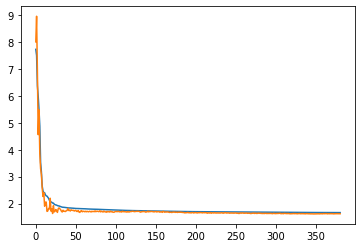

In [24]:
y_pred = regressor.predict(scaled_X_test)
print(f"Loss on test data: {mean_absolute_error(y_test, y_pred)}")

fig, ax = plt.subplots(1, 1)

ax.plot(regressor.training_loss_history)
ax.plot(regressor.validation_loss_history)

plt.show()

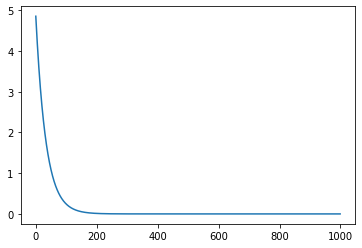

In [25]:
y = []
xrange = 1000

for x in range(1, xrange + 1):
    y.append(5 * 1 / math.exp(x / (xrange / (10 * math.log10(xrange)))))

plt.plot(list(range(xrange)), y)

1.1


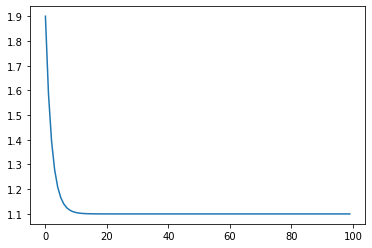

In [75]:
epochs = 100
#y = lambda epoch: 

f = lambda x: 1.1 + 0.8 * math.exp(-x * (50 / (epochs)))

a = list(range(epochs))
alist = [f(x) for x in a]


print(alist[-1])
fig, ax = plt.subplots(1, 1)
ax.plot(alist)